In [9]:
import tensorflow as tf
import datetime, os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [10]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Introduction

We have learned about many different types, architectures and applications of neural networks. This assignement combines our knowledge of networks to compare their differences on a common problem. The dataset is a modified version of the FairFace dataset, which cotains tens of thousands of images of faces and labels about their demographic information. The dataset has been modified to contain greyscale 32x32 versions of the images to let our computers not melt. The goal of this assignment is to train models to predict the age and gender of a person from their face. We will compare the performance of different types of networks. First will be a simple fully connected network, then a small convolutional network, a larger convolutional network. These will be trained and run with both problems and a final network will be created that solves both problems at once.

In [11]:
def get_image(fp):
    """
    return the 32x32 greyscale array
    """
    img = Image.open(fp)
    return np.asarray(img)


In [13]:
# Create train and test data from csvs in train and test folders
train_data = pd.read_csv('fairface_label_train.csv')
test_data = pd.read_csv('fairface_label_val.csv')

# Replace the file column with the actual images using get_image function
train_X = np.array([get_image(fp) for fp in train_data['file']])
test_X = np.array([get_image(fp) for fp in test_data['file']])

# Get the labels, 0 for Male and 1 for Female
gender_train_Y = np.array([(0,1) if x == 'Female' else (1,0) for x in train_data['gender']])
gender_test_Y = np.array([(0,1) if x == 'Female' else (1,0) for x in test_data['gender']])


# Get the labels
age_train_Y = np.array([np.zeros(9) for x in train_data['age']])
age_test_Y = np.array([np.zeros(9) for x in test_data['age']])

age_dict = {
    '0-2': 0,
    '3-9': 1,
    '10-19': 2,
    '20-29': 3,
    '30-39': 4,
    '40-49': 5,
    '50-59': 6,
    '60-69': 7,
    'more than 70': 8
}

for i, age in enumerate(train_data['age']):
    age_train_Y[i][age_dict[age]] = 1

for i, age in enumerate(test_data['age']):
    age_test_Y[i][age_dict[age]] = 1


# Min max normalize the data
max_val = np.max(train_X)
min_val = np.min(train_X)
train_X = (train_X - min_val) / (max_val - min_val)
test_X = (test_X - min_val) / (max_val - min_val)



## 1: Fully Connected Neural Network

This network is a fully connected network that takes a flatten version of each image as input. The network has 3 hidden layers with 1024, 512, and 100 neurons respectively. The output layer is the number of classes for each problem. The network is trained with a cross entropy loss and the sgd optimizer. The networks were trained for a max of 100 epochs, but early stopping was used to stop training when the validation loss stopped improving.

In [5]:
# Feed forward network with:
    # 1024 neurors with tanh act
    # 512 neurons with sig act
    # 100 neurons with relu act
    # n neurons with softmax act
def create_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(1024, input_shape=(1024,), activation='tanh', name='fc1'))
    model.add(tf.keras.layers.Dense(512, activation='sigmoid', name='fc2'))
    model.add(tf.keras.layers.Dense(100, activation='relu', name='fc3'))
    model.add(tf.keras.layers.Dense(n, activation='softmax', name='output'))
    return model

### 1.1 Gender Classification

In [8]:
gender_model = create_model(2)
gender_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(gender_model.summary())

logdir = os.path.join("logs/1.1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
gender_model.fit(x=np.reshape(train_X, (train_X.shape[0], 1024)), 
                 y=gender_train_Y, 
                 epochs=20, 
                 validation_data=(np.reshape(test_X, (test_X.shape[0], 1024)), gender_test_Y),
                 callbacks=[tensorboard_callback])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 1024)              1049600   
                                                                 
 fc2 (Dense)                 (None, 512)               524800    
                                                                 
 fc3 (Dense)                 (None, 100)               51300     
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
Total params: 1,625,902
Trainable params: 1,625,902
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
32/32 [==============================] - 1s 29ms/step - loss: 0.7018 - accuracy: 0.5100 - val_loss: 0.6941 - val_accuracy: 0.5500
Epoch 2/20
32/32 [============

In [ ]:
# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

### 1.2 Age Classification

In [11]:
age_model = create_model(9)
age_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(age_model.summary())

logdir = os.path.join("logs/1.2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
age_model.fit(x=np.reshape(train_X, (train_X.shape[0], 1024)),
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(np.reshape(test_X, (test_X.shape[0], 1024)), age_test_Y),
                 callbacks=[tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 1024)              1049600   
                                                                 
 fc2 (Dense)                 (None, 512)               524800    
                                                                 
 fc3 (Dense)                 (None, 100)               51300     
                                                                 
 output (Dense)              (None, 9)                 909       
                                                                 
Total params: 1,626,609
Trainable params: 1,626,609
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2711/2711 [==============================] - 15s 5ms/step - loss: 1.8464 - accuracy: 0.2931 - val_loss: 1.8198 - val_accuracy: 0.3092
Epoch 2/100
2711/2711 [==

343/343 [==============================] - 1s 4ms/step
Accuracy:  0.37547927697644695


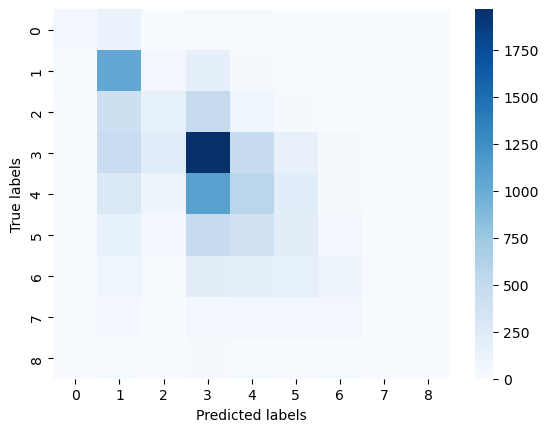

In [13]:
# Create a heatmap confusion matrix
y_pred = age_model.predict(np.reshape(test_X, (test_X.shape[0], 1024)))
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(age_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 2: Small Convolutional Neural Network

This network is a convolutional neural network. It has one convolutional layer with 40 feature detectors each with a size of 5x5 pixels. Next there is a 2x2 max pooling layer before the netowrk is flattened into a fully connected network. The fully connected section has one hidden layer with 100 neurons. The output layer is the number of classes for each problem. The network is trained with a cross entropy loss and the sgd optimizer. The networks were trained for a max of 100 epochs, but early stopping was used to stop training when the validation loss stopped improving.

In [14]:
"""
Convolution layer having 40 feature detectors, with kernel size 5 x 5, and ReLU
as the activation function, with stride 1 and no-padding.
 A max-pooling layer with pool size 2x2.
 Fully connected layer with 100 neurons, and ReLU as the activation function.
 Output layer: n (depending on the task) neurons representing the n classes, using
the softmax activation function. function for each of the 10 neurons
"""
def create_CNN_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(40, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1), name='conv1'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(100, activation='relu', name='fc1'))
    model.add(tf.keras.layers.Dense(n, activation='softmax', name='output'))
    return model

### 2.1

In [19]:
gender_CNN_model = create_CNN_model(2)
gender_CNN_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(gender_CNN_model.summary())

logdir = os.path.join("logs/2.1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
gender_CNN_model.fit(x=train_X, 
                 y=gender_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, gender_test_Y),
                 callbacks=[tensorboard_callback])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 28, 28, 40)        1040      
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 40)        0         
                                                                 
 flatten (Flatten)           (None, 7840)              0         
                                                                 
 fc1 (Dense)                 (None, 100)               784100    
                                                                 
 output (Dense)              (None, 2)                 202       
                                                                 
Total params: 785,342
Trainable params: 785,342
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2711/2711 [====================

KeyboardInterrupt: 

2711/2711 [==============================] - 15s 6ms/step
Accuracy:  0.9985589781425804


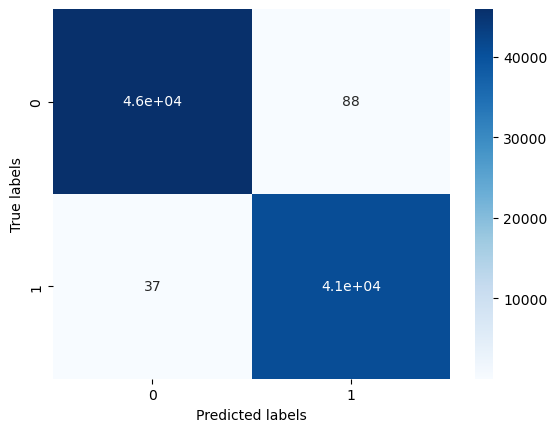

In [20]:

# Create a heatmap confusion matrix
y_pred = gender_CNN_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 2.2

In [16]:
age_CNN_model = create_CNN_model(9)
age_CNN_model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

print(age_CNN_model.summary())

logdir = os.path.join("logs/2.2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
age_CNN_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 28, 28, 40)        1040      
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 40)        0         
                                                                 
 flatten (Flatten)           (None, 7840)              0         
                                                                 
 fc1 (Dense)                 (None, 100)               784100    
                                                                 
 output (Dense)              (None, 9)                 909       
                                                                 
Total params: 786,049
Trainable params: 786,049
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
2711/2711 [====================

KeyboardInterrupt: 

343/343 [==============================] - 1s 4ms/step
Accuracy:  0.41226949059704215


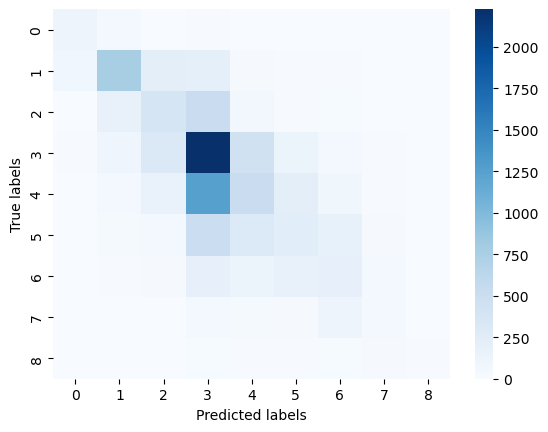

In [17]:
# Create a heatmap confusion matrix
y_pred = age_CNN_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(age_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3: Larger Convolutional Neural Network

This network is a convolutional neural network and is similar to the one above but it contains a large field of view along with more opportunities for nonlinearities and composition of larger features. It has two convolutional layer, one with 40 feature detectors each with a size of 7x7 pixels and another with 80 feature detectors each with a size of 5x5 pixels. Next there is a 2x2 max pooling layer before the netowrk is flattened into a fully connected network. The fully connected section has one hidden layer with 100 neurons. The output layer is the number of classes for each problem. The network is trained with a cross entropy loss and the sgd optimizer. The networks were trained for a max of 100 epochs, but early stopping was used to stop training when the validation loss stopped improving. It will also use the adam optimizer to try and improve the performance of the network.

In [22]:
def create_custom_CNN_model(n):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation='relu', input_shape=(32,32,1), name='conv1'))
    model.add(tf.keras.layers.Conv2D(80, kernel_size=(5, 5), activation='relu', name='conv2'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1'))
    model.add(tf.keras.layers.Flatten(name='flatten'))
    model.add(tf.keras.layers.Dense(100, activation='relu', name='fc1'))
    model.add(tf.keras.layers.Dense(n, activation='softmax', name='output'))
    return model

## 3.1

In [ ]:
gender_large_CNN_model = create_CNN_model(2)
gender_large_CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(gender_large_CNN_model.summary())

logdir = os.path.join("logs/3.1", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
gender_large_CNN_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

In [ ]:
# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 3.2

In [24]:
age_large_CNN_model = create_custom_CNN_model(9)
age_large_CNN_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(age_large_CNN_model.summary())

logdir = os.path.join("logs/3.2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
age_large_CNN_model.fit(x=train_X, 
                 y=age_train_Y, 
                 epochs=100, 
                 validation_data=(test_X, age_test_Y),
                 callbacks=[tensorboard_callback])

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 17, 17, 40)        10280     
                                                                 
 conv2 (Conv2D)              (None, 10, 10, 40)        102440    
                                                                 
 conv3 (Conv2D)              (None, 7, 7, 40)          25640     
                                                                 
 pool1 (MaxPooling2D)        (None, 3, 3, 40)          0         
                                                                 
 flatten (Flatten)           (None, 360)               0         
                                                                 
 fc1 (Dense)                 (None, 50)                18050     
                                                                 
 output (Dense)              (None, 9)                

343/343 [==============================] - 6s 10ms/step
Accuracy:  0.3637940478364068


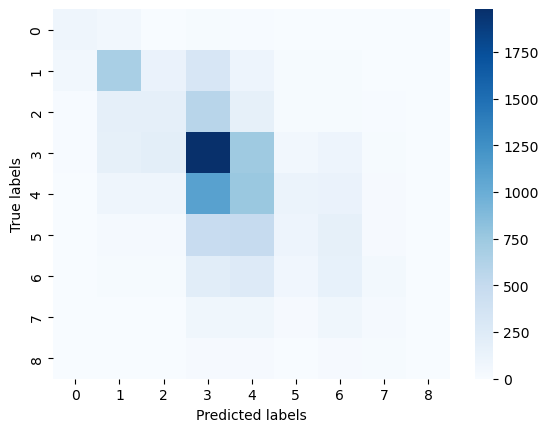

In [26]:
# Create a heatmap confusion matrix
y_pred = age_large_CNN_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(age_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 4: Combined Model

https://towardsdatascience.com/multi-task-learning-for-computer-vision-classification-with-keras-36c52e6243d2

This network has a common convolutional network stem that is shared between both the age and gender tasks. This convolutional stem is the same as the one above and after the flatten layer the two tasks split off. The two branches each have one fully connected layer of 100 neurons and then the output layers whose number of neurons depends on the classes of the task that branch is for. The network is trained with a cross entropy loss and the sgd optimizer. The networks were trained for a max of 100 epochs, but early stopping was used to stop training when the validation loss stopped improving. 

In [23]:
def create_combined_model():
    input = tf.keras.layers.Input(shape=(32, 32, 1))
    conv1 = tf.keras.layers.Conv2D(40, kernel_size=(7, 7), activation='relu', name='conv1')(input)
    conv2 = tf.keras.layers.Conv2D(80, kernel_size=(5, 5), activation='relu', name='conv2')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), name='pool1')(conv2)
    flatten = tf.keras.layers.Flatten()(pool1)

    # Gender branch
    gender_fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    gender_output = tf.keras.layers.Dense(2, activation='softmax', name='gender_output')(gender_fc1)

    # Age branch
    age_fc1 = tf.keras.layers.Dense(100, activation='relu')(flatten)
    age_output = tf.keras.layers.Dense(9, activation='softmax', name='age_output')(age_fc1)

    return tf.keras.Model(inputs=input, outputs=[gender_output, age_output])

In [25]:
combined_model = create_combined_model()
gamma = 0.5
combined_model.compile(optimizer='sgd',
                       loss={'age_output': 'categorical_crossentropy',
                             'gender_output': 'binary_crossentropy'},
                       loss_weights={'age_output': gamma,
                                     'gender_output': 1 - gamma},
                        metrics=['accuracy'])
combined_model.summary()

logdir = os.path.join(
    "logs/4", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Train the model
combined_model.fit(x=train_X,
                   y={'gender_output': gender_train_Y,
                      'age_output': age_train_Y},
                   epochs=100,
                   validation_data=(test_X, {'gender_output': gender_test_Y,
                                             'age_output': age_test_Y}),
                   callbacks=[tensorboard_callback])


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv1 (Conv2D)                 (None, 26, 26, 40)   2000        ['input_9[0][0]']                
                                                                                                  
 conv2 (Conv2D)                 (None, 22, 22, 80)   80080       ['conv1[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 11, 11, 80)   0           ['conv2[0][0]']                  
                                                                                            

KeyboardInterrupt: 

In [ ]:
# Create a heatmap confusion matrix
y_pred = gender_model.predict(test_X)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(gender_test_Y, axis=1)

# Print the final accuracy
print('Accuracy: ', np.sum(y_pred == y_true) / len(y_true))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# Results

## Heatmap of Confusion Matrix

Model |Gender             |  Age
:---------------------:|:-------------------------:|:-------------------------:
1 | ![1.1_heatmap](result_graphics/1.1_heatmap.png)  |  ![1.2_heatmap](result_graphics/1.2_heatmap.png)
2 | ![2.1_heatmap](result_graphics/2.1_heatmap.png)  |  ![2.2_heatmap](result_graphics/2.2_heatmap.png)
3 | ![3.1_heatmap](result_graphics/3.1_heatmap.png)  |  ![3.2_heatmap](result_graphics/3.2_heatmap.png)
4 | ![4.1_heatmap](result_graphics/4.1_heatmap.png)  |  ![4.2_heatmap](result_graphics/4.2_heatmap.png)

## Epoch-Loss Graphs

| Model | Gender             |  Age
|-------|:-----------------:|:-------------------------:
| 1     |<img src="result_graphics/1.1_epoch_loss.svg" width="600" height="600">  |  <img src="result_graphics/1.2_epoch_loss.svg" width="600" height="600">
| 2     |<img src="result_graphics/2.1_epoch_loss.svg" width="600" height="600">  |  <img src="result_graphics/2.2_epoch_loss.svg" width="600" height="600">
| 3     |<img src="result_graphics/3.1_epoch_loss.svg" width="600" height="600">  |  <img src="result_graphics/3.2_epoch_loss.svg" width="600" height="600">
| 4     |<img src="result_graphics/4.1_epoch_loss.svg" width="600" height="600">  |  



## Epoch-Accuracy Graphs

| Model | Gender             |  Age
|-------|:-----------------:|:-------------------------:
| 1     |<img src="result_graphics/1.1_epoch_accuracy.svg" width="600" height="600">  |  <img src="result_graphics/1.2_epoch_accuracy.svg" width="600" height="600">
| 2     |<img src="result_graphics/2.1_epoch_accuracy.svg" width="600" height="600">  |  <img src="result_graphics/2.2_epoch_accuracy.svg" width="600" height="600">
| 3     |<img src="result_graphics/3.1_epoch_accuracy.svg" width="600" height="600">  |  <img src="result_graphics/3.2_epoch_accuracy.svg" width="600" height="600">


## Final Classification Accuracy

Model |Gender             |  Age
:---------------------:|:-------------------------:|:-------------------------:
1 | 0.7683  |  0.4025
2 | 0.8096  |  0.4312
3 | 0.8043  |  0.3903
4 | 0.8  |  0.39

## Conclusion

Image classification is a tough problem. Low resolution greyscale images make things easier for our computers to run and train these models but they take away potentially useful resolution. This made predicting the age very hard especially with 9 different categories to classify. The age classification accuracy never got very good, the gender problem only has two class and faired much better. Of the models tried, the first big choice that led to significant performance improvement was to use a CNN. These performed about 4% more accuratly on the gender task. Of the small optimizations that we tried to implement, only slight improvement was possible over the basic CNN with a larger field of view and the adam optimizer. The combined model did not perform as well as the single task models. This could be because the two tasks are not related enough to benefit from sharing the convolutional stem. We also observed overfitting in alot of these models which is very obvious in the loss graphs. This is a problem that we could have tried to solve by using dropout layers or other regularization techniques.